## Allie Surina - NYC - Technical Report:
### There's No Crying in Baseball, Even if You Get on the Disabled List

# Project Outline:

- ### Problem Statement

- ### Data
    - Gathering, Cleaning, Record Linkage
- ### Models
    - Logistic Regression, k-NN, Random Forest Classifier, **Gradient Boosting Classifier**
- ### Model Evaluation
- ### Next Steps



---


# Problem Statement:
This project designs a machine learning classification model to predict whether a Major League Baseball game Disabled List (DL) placement will happen after a game during regular season. Using historical data of game logs and DL placements occuring between March 2000 and October 2016, I predicted DL placements with 88% accuracy using a Logistic Regression model.

---


# Data

<img src="https://i.imgur.com/9l5BXKV.jpg" height="300px"></img>

---


## Gathering Data

The gamelog and Disabled List placement data for this project were imported, web-scraped and linked using that Pandas and Beautiful Soup packages in Python. The two main web sources were www.retrosheet.org (gamelog and player .csv files) and www.prosportstransactions.com (web-scraped Disabled List HTML tables). 

### Gamelog Data: 
The File I/O and data cleaning for gamelog data can be found in the Jupyter Notebook <a href="https://github.com/robotallie/mlb-disabled-list/blob/master/datasets/baseball-game-logs-file-imports.ipynb">`'baseball-game-logs-file-imports.ipynb'`</a>. The CSV file created from the web scrape, `'gamelogs.csv'` can be found in the <a href="https://github.com/robotallie/mlb-disabled-list/tree/master/datasets">datasets</a> folder.
    
From <a href="http://www.retrosheet.org">www.retrosheet.org</a>, I downloaded 18 seasons of gamelog files, for games from 2000 to 2016. I concatenated them into one, continuous dataframe, assigning names to the 161 columns using a text-based data dictionary given for the gamelogs on the Retro Sheet website. The dataframe had 43,727 rows, each row containing information about one regular season game between a home and visiting team. 

The five main types of data provided in each row of the data includes:
* Visiting and home team names, leagues and game number in season
* Date of game, time of day, ballpark id
* Stats for both the visiting and home teams during the game (e.g. visiting team's RBI)
* IDs, names and positions for the starting lineup
* IDs and names for managers, umpires, starting pitchers, and winning and losing pitchers
    
To clean the data, I performed the following tasks:
* Removed 65 of the 161 columns that either had high proportions of null values, had redundant information or were not relevant to my data model (e.g. umpire names and IDs, player positions and names, whether a game was forfeited or not, etc.).
* Imputed null values for park attendance to the mean park attendance for that year.
* Removed 7 remaining rows that had null values.
* Removed duplicate rows (total of 2,428 duplicate rows removed, bringing the number of rows down to 41,292 and the number of columns to 96.
* Combined visiting league and home league into one feature, called `intra_league` that was equal to 1 if the visiting and home league were the same, and 0 if a team played a team from another league.
* Converted the date column into a datetime data type and set the date as the dataframe index, keeping the original index as a new column called `'real_index'`.


### Disabled List Placement Data:
The web scraping and data cleaning for Disabled List data can be found in the Jupyter Notebook <a href="https://github.com/robotallie/mlb-disabled-list/blob/master/datasets/injury_data_scrape.ipynb">`'injury_data_scrape.ipynb'`</a>. The CSV file created from the web scrape, `'injuries.csv'` can be found in the <a href="https://github.com/robotallie/mlb-disabled-list/tree/master/datasets">datasets</a> folder.

I was able to scrape Disabled List data from 657 pages of HTML tabular search results from Pro Sports Transactions, <a href="http://www.prosportstransactions.com/">http://www.prosportstransactions.com/</a>. The resulting dataframe had 16,403 rows and 5 columns, consisting of the following information regarding players being placed on the list and reactivated to active play:
* `"Date"`, `"Team"`, `"Acquired Player name"`, `"Relinquished Player name"`, `"Notes"`: (e.g. "placed on 15-day DL with hip injury", "laced on 15-day DL with strained groin")

To clean the data and link the records in the Disabled List dataframe with gamelog records, I transformed the current columns and created four new columns:
* I removed bullet points from the player names in `"Acquired Player Name"`.
* I converted the date column from the format '2000-03-23' to the formate '20000323' to match the gamelogs.
* `"Injured"`: This column is 1 if the row has an entry for "Relinquished Player Name", and 0 if the row has an entry for `"Acquired Player Name"`. This column is used to remove all rows that are not a Disabled List placement, but are instead a player coming back into play.
* `"DL_Length"`: Using Natural Language Processing on the `"Notes"` column, I extracted the length of time the injured player was on the DL list, coding unknowns as zeros and then replacing the zeros with the median value of 15 later. 
* `"Injury_Type"`: Using Natural Language Processing on the `"Notes"` column, I extracted the type of injury related to the DL placement. 49% of the rows did not have an injury type recorded, which I coded with the string, 'Unknown'.
* `"Player_Id"`: Using the CSV file, `MLBPlayerIds.csv`, from <a href="http://www.retrosheet.org">http://www.retrosheet.org</a>, which contains MLB player names, IDs and debut dates going back over one hundred years, I created a data dictionary to help me map players names from the Disabled List to their retrosheet.org player IDs. The `'Player_Id'` column is used to link records from the DL to the gamelogs in the Jupyter Notebook called `gamelog-injury-merge.ipynb`. I ended up dropping 1273 null values in the final datframe, because for 1273 players, there wasn't a perfect match between a name on the DL and names in the player id list. This is something to work on later, trying to make perfect matches using FuzzyWuzzy or other matching packages in Python.
* `"Team_slug"`: Using the CSV file, `TeamCurrentNames.csv` from retrosheet.org, I created a data dictionary with slugs and team names and used the package **`FuzzyWuzzy`** to find the closest match between the name of a team in the `"Team"` column of the Disabled List data and the `'Team'` name in the team slugs data dictionary, `team_slugs_df`. The method of **`FuzzyWuzzy`** extracts any number of similar items to the first value you give it, which in this case will be the cell in the column of 'Team'. e.g. `'Orioles'` in `injury_df['Team']` should by closes to `'Orioles'` in the dictionary, which is the key matching the value of the slug `'BAL'`.

I dropped 245 duplicates and reduced the final dataframe for DL placements to only three columns: `"Date"`, `"DL_Length"` and `"player_id"`.

I saved the dataframe to a CSV file named `'injuries.csv'`, which is in the <a href="https://github.com/robotallie/mlb-disabled-list/tree/master/datasets">datasets</a> folder of the repository, and which I use to bring the data into the main <a href="https://github.com/robotallie/mlb-disabled-list/blob/master/MLB-disabled-list-predictions.ipynb">`baseball-injury-predictions.ipynb`</a>.
    
## Record Linkage between Disabled List and Game Log Data
I sorted the gamelogs by date and reset the index to make sure that the gamelogs were in order by date and to make sure that the original indexes from the 18 separate datasets were completely replaced with a new, continuous, unique index. I set the datetime date as the index and kept the unique index Series from 0 to 41291 as a column to use as the key for updating dataframe rows later.

I created a column of zeros called "injury", to serve as the target for the model. The column was updated using a defined function that found that last game that a player on the Disabled List played before being placed there.

The function,  took in as parameters the `gamelogs` dataframe, and the date of placement and player's ID from the `injury` dataframe. The function selected all games from the gamelogs that occured during a set window (I eventually chose 200 days, to maximize the number of matches) before that DL placement date. Looping through those selected games, the function located all the games in which that DL player's ID was matched to a starting lineup column, and saved the location index of the last game. The index was used as a key to update the `"injury"` column by setting it to a 1. 

After all the matches were found between Disabled List placements and the gamelogs, there were 2,647 DL placements for which a "last game" was not found. A follow-up project will allow me to spend time improving the matching function so that 1/3 of the data is not lost on record-linkage issues.

Once I had the target column set, I dropped the columns for the real index and all of the player id columns, and encoded all of the categorical columns (e.g. day/night, team names) to dummies. I did not have to worry about data leakage while converting to dummies before splitting data into training and testing data, becuase all of the categories would be represented in each split of the data.

The final CSV of the X and y combined dataframe was saved as `games_features_for_model.csv` in the datasets folder.


---


# Model & Evaluation
The model and evaluation can be found in the Jupyter Notebook <a href="https://github.com/robotallie/mlb-disabled-list/blob/master/MLB-disabled-list-predictions.ipynb">MLB-disabled-list-predictions.ipynb</a>.

I used a machine learning classification model to predict whether a Disabled List placement would occur after a game in the regular season. For the sake of learning and practice, I worked with Logistic Regression, k-NN and Random Forest Classifiers before developing a Gradient Boosting Classifier model. I knew that an ensemble method in which each subsequent classifier built off the results of the previous classifier would be well-suited to my target variable's imbalanced classes (i.e. 87% of the target's rows were zeros). 

Due to the unbalanced classes of my target, even though the model's accuracy was 87%, the model was better at predicting negative outcomes than at positive outcomes. The model's default cutoff classifies all rows with predicted probabilities greater than 0.5 as ones, but this resulted in a true positive rate of only 1.6% and true negative rate of 99.8%. Scikit-learn's methods allow me to output predicted probabilities for each row's likelihood of having a disabled list placement after a game, and I used these to adjust the threshold to imcrease the true positive rate. With a threshold of 0.05 instead, I was able to obtain a true positive rate of 99%, but unfortunately, that resulted in a true negative rate of 1%.

Creating a Reciever Operating Characteristic curve for the predictions, I found that the greatest area under the curve (0.63) was obtained with a 0.5 threshold for the predicted probability classification. However, the 0.1 threshold obtained a close AUC of 0.57.

For the Gradient Boosting Classifier model with all features:
* My **accuracy score was 87%**
* My **AUC score (area under the ROC curve) was 0.63 with a 0.50 threshold**.
* The confusion matrix showed that the model's precision and recall were much better for the 0 class (no DL placement) than for the 1 class (a DL placement did occur), positively classifying 11866 True Negatives  and positively classifying 28 True Positives. 
* As I lowered the threshold from 0.50 down to 0.30, 0.20 and 0.10, the number of `false negatives` was reduced drastically down to 129 and the number of `true positives` increased to 1734.

In plot of the ROC curves with varying thresholds below, the ROC curve that represents the most area under the curve does not actually provide the greatest sensitivity to predicting true positives. 

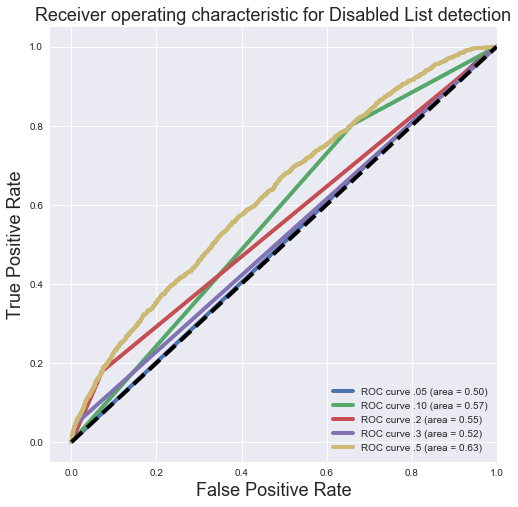



# Cross Validation with Other Models
* Cross validating with Logistic Regression, k-NN, and Random Forests resulted in lower overall accuracy of 0.872 and AUC score of 0.514, but increased accuracy in predicting class 1.
* Cross validating with a Random Forest Classifier, using a grid search, resulted in a similar accuracy of 88.1% and an AUC score of 0.567. The best parameters were a max depth of 10, a minimum number of 4 samples at the leaf nodes, and 9 trees in the forest.
* Cross validating with Gradient Boosting Classifer resulted in an accuracy of **0.881 and the highest AUC score of 63.3%**. This ROC Curve is shown below:
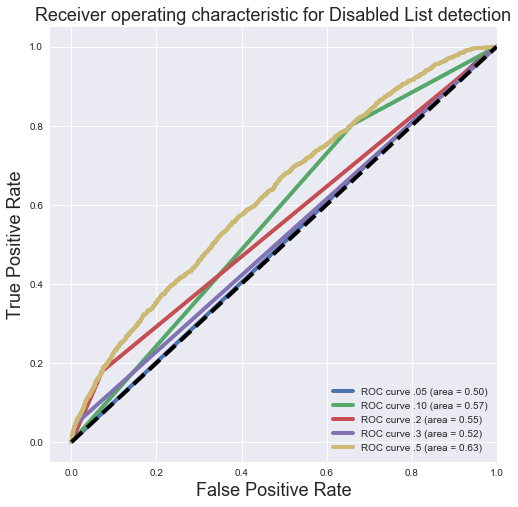
---


# Next Steps
* I plan to do more feature engineering to create features that capture the differential between team ages and years in play, using the `"debut_date"` I captured in the retrosheet.org `MLBPlayerIDs.csv`. 
* I plan to do PCA for feature extraction after I add more features, to reduce the number of dimensions of my data to only the inner dimensions that account for the variance in the data. The current PCA found not much of a reduction in features. 
* I plan to evaluate the composition of games that result in a Disabled List placement with those that do not, using cluster analysis.